# 0. Set up

In [1]:
## Import packages
import gc
import os
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lightgbm as lgb
import shap

from pandas_profiling import ProfileReport

In [2]:
user = os.getenv('USERNAME')
shared_workspace = '/home/nikankarla/modelling_club_team9'
user_dir = os.path.join(shared_workspace, user)
data_dir = os.path.join(shared_workspace, 'raw_data')
model_file_output_dir = os.path.join(data_dir, 'engineered/bureau/')
scoreboard_path = os.path.join(shared_workspace, "scoreboard/model_scores.json")

In [3]:
seed = 2021
response = 'TARGET'
primary_keys = ['SK_ID_CURR']
split = 'SPLIT'
non_feature_cols = primary_keys + [response] + [split]

# 1. Import data

In [4]:
home_loan_train = pd.read_csv(data_dir + '/raw/application_train.csv',index_col='SK_ID_CURR')
home_loan_test = pd.read_csv(data_dir + '/raw/application_test_noTarget.csv',index_col='SK_ID_CURR')

bureau = pd.read_csv(data_dir + '/raw/bureau.csv')
# bureau_balance = pd.read_csv(data_dir + '/raw/bureau_balance.csv',index_col='SK_ID_BUREAU')

In [5]:
train_response = home_loan_train['TARGET']

## Cleaning

In [6]:
bureau = bureau[bureau["CREDIT_CURRENCY"]=='currency 1']
bureau = bureau.drop("CREDIT_CURRENCY",axis=1)

In [7]:
## Active
# Consumer Credit
Active_ConsumerCredit = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Active') & (bureau["CREDIT_TYPE"] == "Consumer credit")]
Active_ConsumerCredit = Active_ConsumerCredit.drop(["DAYS_ENDDATE_FACT","CREDIT_ACTIVE","CREDIT_TYPE"],axis=1)
Active_ConsumerCredit["COUNT"] = Active_ConsumerCredit[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

# Credit Card
Active_CreditCard = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Active') & (bureau["CREDIT_TYPE"] == "Credit card")]
Active_CreditCard = Active_CreditCard.drop(["DAYS_ENDDATE_FACT","CREDIT_ACTIVE","CREDIT_TYPE"],axis=1)
Active_CreditCard["COUNT"] = Active_CreditCard[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

# Mortgage
Active_Mortgage = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Active') & (bureau["CREDIT_TYPE"] == "Mortgage")]
Active_Mortgage = Active_Mortgage.drop(["DAYS_ENDDATE_FACT","CREDIT_ACTIVE","CREDIT_TYPE"],axis=1)
Active_Mortgage["COUNT"] = Active_Mortgage[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

# Other
Active_Other = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Active') & (bureau["CREDIT_TYPE"] == "Car loan")]
Active_Other = Active_Other.drop(["DAYS_ENDDATE_FACT","CREDIT_ACTIVE"],axis=1)
Active_Other["COUNT"] = Active_Other[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')


## Closed
# Consumer Credit
Closed_ConsumerCredit = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Closed') & (bureau["CREDIT_TYPE"] == "Consumer credit")]
Closed_ConsumerCredit = Closed_ConsumerCredit.drop(["CREDIT_ACTIVE","CREDIT_TYPE"],axis=1)
Closed_ConsumerCredit["COUNT"] = Active_ConsumerCredit[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

# Credit Card
Closed_CreditCard = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Closed') & (bureau["CREDIT_TYPE"] == "Credit card")]
Closed_CreditCard = Closed_CreditCard.drop(["CREDIT_ACTIVE","CREDIT_TYPE"],axis=1)
Closed_CreditCard["COUNT"] = Closed_CreditCard[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

# Mortgage
Closed_Mortgage = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Closed') & (bureau["CREDIT_TYPE"] == "Mortgage")]
Closed_Mortgage = Closed_Mortgage.drop(["CREDIT_ACTIVE","CREDIT_TYPE"],axis=1)
Closed_Mortgage["COUNT"] = Closed_Mortgage[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

# Other
Closed_Other = bureau.loc[(bureau["CREDIT_ACTIVE"] == 'Closed') & (bureau["CREDIT_TYPE"] == "Car loan")]
Closed_Other = Closed_Other.drop(["CREDIT_ACTIVE"],axis=1)
Closed_Other["COUNT"] = Closed_Other[["SK_ID_CURR","SK_ID_BUREAU"]].groupby("SK_ID_CURR").transform('count')

## LOAN DICT
Loan_Dict = {"Active_ConsumerCredit":Active_ConsumerCredit,
             "Active_CreditCard":Active_CreditCard,
             "Active_Mortgage":Active_Mortgage,
             "Active_Other":Active_Other,
             "Closed_ConsumerCredit":Closed_ConsumerCredit,
             "Closed_CreditCard":Closed_CreditCard,
             "Closed_Mortgage":Closed_Mortgage,
             "Closed_Other":Closed_Other
              }


## Look at coverage in train and test

In [8]:
for df in Loan_Dict.keys():
    print(df)
    print("%train: {0:.1f}%".format(100*home_loan_train.merge(Loan_Dict[df]["SK_ID_CURR"].drop_duplicates().to_frame(),on="SK_ID_CURR",how="inner").shape[0]/home_loan_train.shape[0]))
    print("%test : {0:.1f}%".format(100*home_loan_test.merge(Loan_Dict[df]["SK_ID_CURR"].drop_duplicates().to_frame(),on="SK_ID_CURR",how="inner").shape[0]/home_loan_test.shape[0]))

Active_ConsumerCredit
%train: 52.8%
%test : 52.9%
Active_CreditCard
%train: 48.3%
%test : 48.0%
Active_Mortgage
%train: 3.4%
%test : 3.4%
Active_Other
%train: 2.7%
%test : 2.7%
Closed_ConsumerCredit
%train: 71.9%
%test : 72.0%
Closed_CreditCard
%train: 21.6%
%test : 21.6%
Closed_Mortgage
%train: 1.3%
%test : 1.2%
Closed_Other
%train: 4.1%
%test : 4.1%


In [9]:
print(home_loan_train.shape)
print(home_loan_test.shape)

(215257, 121)
(92254, 120)


## Investigation

### Active_Mortgage

In [10]:
Active_Mortgage_Singl = Active_Mortgage[Active_Mortgage["COUNT"]<=1]
Active_Mortgage_Dupes = Active_Mortgage[Active_Mortgage["COUNT"]>1]
Active_Mortgage_Dupes["COUNT"] = Active_Mortgage_Dupes[["SK_ID_CURR","SK_ID_BUREAU"]].groupby('SK_ID_CURR').transform('count') 
Active_Mortgage_Dupes = Active_Mortgage_Dupes[Active_Mortgage_Dupes['DAYS_CREDIT_UPDATE'] == Active_Mortgage_Dupes.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].transform('min')]
Active_Mortgage_Dupes = Active_Mortgage_Dupes[Active_Mortgage_Dupes['DAYS_CREDIT'] == Active_Mortgage_Dupes.groupby('SK_ID_CURR')['DAYS_CREDIT'].transform('min')]
Active_Mortgage_Dupes = Active_Mortgage_Dupes[Active_Mortgage_Dupes['AMT_CREDIT_SUM'] == Active_Mortgage_Dupes.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].transform('max')]
Active_Mortgage_Dupes = Active_Mortgage_Dupes[Active_Mortgage_Dupes["DAYS_CREDIT_ENDDATE"].notnull()]
Active_Mortgage_Dupes = Active_Mortgage_Dupes.drop_duplicates(subset=['SK_ID_CURR'])
Active_Mortgage_Clean = pd.concat([Active_Mortgage_Singl, Active_Mortgage_Dupes])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
print(Active_Mortgage_Clean.shape)
print(len(Active_Mortgage_Clean["SK_ID_CURR"].unique()))

(10374, 14)
10374


In [12]:
Active_Mortgage_Clean.to_csv(model_file_output_dir + "Active_Mortgage_Clean.csv",index=False)

### Closed_Mortgage

In [13]:
Closed_Mortgage_Singl = Closed_Mortgage[Closed_Mortgage["COUNT"]<=1]
Closed_Mortgage_Dupes = Closed_Mortgage[Closed_Mortgage["COUNT"]>1]
Closed_Mortgage_Dupes["COUNT"] = Closed_Mortgage_Dupes[["SK_ID_CURR","SK_ID_BUREAU"]].groupby('SK_ID_CURR').transform('count') 
Closed_Mortgage_Dupes = Closed_Mortgage_Dupes[Closed_Mortgage_Dupes['DAYS_CREDIT_UPDATE'] == Closed_Mortgage_Dupes.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].transform('min')]
Closed_Mortgage_Dupes = Closed_Mortgage_Dupes[Closed_Mortgage_Dupes['DAYS_ENDDATE_FACT'] == Closed_Mortgage_Dupes.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].transform('min')]
Closed_Mortgage_Dupes = Closed_Mortgage_Dupes[Closed_Mortgage_Dupes['AMT_CREDIT_SUM'] == Closed_Mortgage_Dupes.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].transform('max')]
Closed_Mortgage_Dupes = Closed_Mortgage_Dupes.drop_duplicates(subset=['SK_ID_CURR'])
Closed_Mortgage_Clean = pd.concat([Closed_Mortgage_Singl, Closed_Mortgage_Dupes])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
print(Active_Mortgage_Clean.shape)
print(len(Active_Mortgage_Clean["SK_ID_CURR"].unique()))

(10374, 14)
10374


In [20]:
Closed_Mortgage_Clean.to_csv(model_file_output_dir + "Closed_Mortgage_Clean.csv",index=False)

### Active Consumer Credit

In [21]:
def conCred_year_brackets(year):
    if (year >= -1): return 1
    elif (year >= -2): return 2
    else: return 3

In [22]:
Active_ConsumerCredit = Active_ConsumerCredit.sort_values(["SK_ID_CURR","DAYS_CREDIT","DAYS_CREDIT_UPDATE"])
Active_ConsumerCredit = Active_ConsumerCredit.drop_duplicates(subset=["SK_ID_CURR", "DAYS_CREDIT"], keep='last')
Active_ConsumerCredit["YEARS_CREDIT"] = Active_ConsumerCredit["DAYS_CREDIT"]/365
Active_ConsumerCredit["DATE_RANGE"] = Active_ConsumerCredit["YEARS_CREDIT"].apply(conCred_year_brackets)

In [23]:
Active_ConsumerCredit_Agg = Active_ConsumerCredit.groupby(["SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         COUNT=('COUNT',sum)
        )

In [24]:
Active_ConsumerCredit_Agg.to_csv(model_file_output_dir + "Active_ConsumerCredit_Agg.csv")

In [25]:
Active_ConsumerCredit_Agg_Date = Active_ConsumerCredit.groupby(["DATE_RANGE","SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         COUNT=('COUNT',sum)
        )

In [26]:
Active_ConsumerCredit_Agg_Date.to_csv(model_file_output_dir + "Active_ConsumerCredit_Agg_Date.csv")

### Closed Consumer Credit

In [27]:
def closedConCred_year_brackets(year):
    if (year >= -2): return 1
    elif (year >= -4): return 2
    else: return 3

In [28]:
Closed_ConsumerCredit = Closed_ConsumerCredit.sort_values(["SK_ID_CURR","DAYS_CREDIT","DAYS_CREDIT_UPDATE"])
Closed_ConsumerCredit = Closed_ConsumerCredit.drop_duplicates(subset=["SK_ID_CURR", "DAYS_CREDIT"], keep='last')
Closed_ConsumerCredit["YEARS_ENDDATE_FACT"] = Closed_ConsumerCredit["DAYS_ENDDATE_FACT"]/365
Closed_ConsumerCredit["DATE_RANGE"] = Closed_ConsumerCredit["YEARS_ENDDATE_FACT"].apply(closedConCred_year_brackets)

In [29]:
Closed_ConsumerCredit_Agg = Closed_ConsumerCredit.groupby(["SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         COUNT=('COUNT',sum)
        )

In [30]:
Closed_ConsumerCredit_Agg.to_csv(model_file_output_dir + "Closed_ConsumerCredit_Agg.csv")

In [31]:
Closed_ConsumerCredit_Agg_Date = Closed_ConsumerCredit.groupby(["DATE_RANGE","SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         COUNT=('COUNT',sum)
        )

In [32]:
Closed_ConsumerCredit_Agg_Date.to_csv(model_file_output_dir + "Closed_ConsumerCredit_Agg_Date.csv")

### Active Credit Card

In [33]:
def credCard_year_brackets(year):
    if (year >= -1): return 1
    elif (year >= -2): return 2
    elif (year >= -4): return 3
    else: return 4

In [34]:
Active_CreditCard = Active_CreditCard.sort_values(["SK_ID_CURR","DAYS_CREDIT","DAYS_CREDIT_UPDATE"])
Active_CreditCard = Active_CreditCard.drop_duplicates(subset=["SK_ID_CURR", "DAYS_CREDIT"], keep='last')
Active_CreditCard["YEARS_CREDIT"] = Active_CreditCard["DAYS_CREDIT"]/365
Active_CreditCard["DATE_RANGE"] = Active_CreditCard["YEARS_CREDIT"].apply(credCard_year_brackets)

In [35]:
Active_CreditCard_Agg = Active_CreditCard.groupby(["SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         AMT_CREDIT_SUM_LIMIT=('AMT_CREDIT_SUM_LIMIT', sum),
         AMT_CREDIT_SUM_LIMIT_MAX=('AMT_CREDIT_SUM_LIMIT', max),
         COUNT=('COUNT',sum)
        )

In [36]:
Active_CreditCard_Agg.to_csv(model_file_output_dir + "Active_CreditCard_Agg.csv")

In [37]:
Active_CreditCard_Agg_Date = Active_CreditCard.groupby(["DATE_RANGE","SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         AMT_CREDIT_SUM_LIMIT=('AMT_CREDIT_SUM_LIMIT', sum),
         AMT_CREDIT_SUM_LIMIT_MAX=('AMT_CREDIT_SUM_LIMIT', max),
         COUNT=('COUNT',sum)
        )

In [38]:
Active_CreditCard_Agg_Date.to_csv(model_file_output_dir + "Active_CreditCard_Agg_Date.csv")

### Closed Credit Card

In [39]:
def closedCredCard_year_brackets(year):
    if (year >= -1): return 1
    elif (year >= -2): return 2
    elif (year >= -4): return 3
    else: return 4

In [40]:
Closed_CreditCard = Closed_CreditCard.sort_values(["SK_ID_CURR","DAYS_CREDIT","DAYS_CREDIT_UPDATE"])
Closed_CreditCard = Closed_CreditCard.drop_duplicates(subset=["SK_ID_CURR", "DAYS_CREDIT"], keep='last')
Closed_CreditCard["YEARS_ENDDATE_FACT"] = Closed_CreditCard["DAYS_ENDDATE_FACT"]/365
Closed_CreditCard["DATE_RANGE"] = Closed_CreditCard["YEARS_ENDDATE_FACT"].apply(closedCredCard_year_brackets)

In [41]:
Closed_CreditCard_Agg = Closed_CreditCard.groupby(["SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_LIMIT=('AMT_CREDIT_SUM_LIMIT', sum),
         AMT_CREDIT_SUM_LIMIT_MAX=('AMT_CREDIT_SUM_LIMIT', max),
         COUNT=('COUNT',sum)
        )

In [42]:
Closed_CreditCard_Agg.to_csv(model_file_output_dir + "Closed_CreditCard_Agg.csv")

In [43]:
Closed_CreditCard_Agg_Date = Closed_CreditCard.groupby(["DATE_RANGE","SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         CNT_CREDIT_PROLONG=('CNT_CREDIT_PROLONG', sum),
         CNT_CREDIT_PROLONG_MAX=('CNT_CREDIT_PROLONG', max),
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_LIMIT=('AMT_CREDIT_SUM_LIMIT', sum),
         AMT_CREDIT_SUM_LIMIT_MAX=('AMT_CREDIT_SUM_LIMIT', max),
         COUNT=('COUNT',sum)
        )

In [44]:
Closed_CreditCard_Agg_Date.to_csv(model_file_output_dir + "Closed_CreditCard_Agg_Date.csv")

### Active Other

In [45]:
def other_year_brackets(year):
    if (year >= -1): return 1
    elif (year >= -2): return 2
    else: return 3

In [46]:
Active_Other = Active_Other.sort_values(["SK_ID_CURR","DAYS_CREDIT","DAYS_CREDIT_UPDATE"])
Active_Other = Active_Other.drop_duplicates(subset=["SK_ID_CURR", "DAYS_CREDIT"], keep='last')
Active_Other["YEARS_CREDIT"] = Active_Other["DAYS_CREDIT"]/365
Active_Other["DATE_RANGE"] = Active_Other["YEARS_CREDIT"].apply(other_year_brackets)

In [47]:
Active_Other_Agg = Active_Other.groupby(["SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         AMT_ANNUITY=('AMT_ANNUITY', sum),
         AMT_ANNUITY_MAX=('AMT_ANNUITY', max),
         COUNT=('COUNT',sum)
        )

In [48]:
Active_Other_Agg.to_csv(model_file_output_dir + "Active_Other_Agg.csv")

In [49]:
Active_Other_Agg_Date = Active_Other.groupby(["DATE_RANGE","SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         AMT_ANNUITY_DEBT=('AMT_ANNUITY', sum),
         AMT_ANNUITY_DEBT_MAX=('AMT_ANNUITY', max),
         COUNT=('COUNT',sum)
        )

In [50]:
Active_Other_Agg_Date.to_csv(model_file_output_dir + "Active_Other_Agg_Date.csv")

### Closed Other

In [57]:
def closedOther_year_brackets(year):
    if (year >= -2): return 1
    elif (year >= -4): return 2
    else: return 3

In [58]:
Closed_Other = Closed_Other.sort_values(["SK_ID_CURR","DAYS_CREDIT","DAYS_CREDIT_UPDATE"])
Closed_Other = Closed_Other.drop_duplicates(subset=["SK_ID_CURR", "DAYS_CREDIT"], keep='last')
Closed_Other["YEARS_CREDIT"] = Closed_Other["DAYS_ENDDATE_FACT"]/365
Closed_Other["DATE_RANGE"] = Closed_Other["YEARS_CREDIT"].apply(closedOther_year_brackets)

In [61]:
Closed_Other_Agg = Closed_Other.groupby(["SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         AMT_ANNUITY_DEBT=('AMT_ANNUITY', sum),
         AMT_ANNUITY_DEBT_MAX=('AMT_ANNUITY', max),
         COUNT=('COUNT',sum)
        )

In [62]:
Closed_Other_Agg.to_csv(model_file_output_dir + "Closed_Other_Agg.csv")

In [63]:
Closed_Other_Agg_Date = Closed_Other.groupby(["DATE_RANGE","SK_ID_CURR"]).agg(
         AMT_CREDIT_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', max), 
         AMT_CREDIT_SUM=('AMT_CREDIT_SUM', sum),
         AMT_CREDIT_SUM_MAX=('AMT_CREDIT_SUM', max),
         AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', sum),
         AMT_CREDIT_SUM_DEBT_MAX=('AMT_CREDIT_SUM_DEBT', max),
         AMT_ANNUITY_DEBT=('AMT_ANNUITY', sum),
         AMT_ANNUITY_DEBT_MAX=('AMT_ANNUITY', max),
         COUNT=('COUNT',sum)
        )

In [64]:
Closed_Other_Agg_Date.to_csv(model_file_output_dir + "Closed_Other_Agg_Date.csv")

# ARCHIVE

## Aggregates

Loan count

In [6]:
model_file = bureau[['SK_ID_CURR',"SK_ID_BUREAU"]].groupby('SK_ID_CURR').count()
model_file = model_file.rename(columns={"SK_ID_BUREAU":"LOAN_COUNT"})
model_file["LOAN_COUNT"].loc[model_file["LOAN_COUNT"]>40] = 40

Wide spectrum

In [7]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'max', 'min', 'sum']).reset_index()

In [8]:
model_file = model_file.merge(bureau_agg, on='SK_ID_CURR', how='left')

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [9]:
model_file.columns = [re.sub(r'\W+', '', str(col)) for col in model_file.columns]

Index(['SK_ID_CURR', 'LOAN_COUNT', 'DAYS_CREDITmean', 'DAYS_CREDITmax',
       'DAYS_CREDITmin', 'DAYS_CREDITsum', 'CREDIT_DAY_OVERDUEmean',
       'CREDIT_DAY_OVERDUEmax', 'CREDIT_DAY_OVERDUEmin',
       'CREDIT_DAY_OVERDUEsum', 'DAYS_CREDIT_ENDDATEmean',
       'DAYS_CREDIT_ENDDATEmax', 'DAYS_CREDIT_ENDDATEmin',
       'DAYS_CREDIT_ENDDATEsum', 'DAYS_ENDDATE_FACTmean',
       'DAYS_ENDDATE_FACTmax', 'DAYS_ENDDATE_FACTmin', 'DAYS_ENDDATE_FACTsum',
       'AMT_CREDIT_MAX_OVERDUEmean', 'AMT_CREDIT_MAX_OVERDUEmax',
       'AMT_CREDIT_MAX_OVERDUEmin', 'AMT_CREDIT_MAX_OVERDUEsum',
       'CNT_CREDIT_PROLONGmean', 'CNT_CREDIT_PROLONGmax',
       'CNT_CREDIT_PROLONGmin', 'CNT_CREDIT_PROLONGsum', 'AMT_CREDIT_SUMmean',
       'AMT_CREDIT_SUMmax', 'AMT_CREDIT_SUMmin', 'AMT_CREDIT_SUMsum',
       'AMT_CREDIT_SUM_DEBTmean', 'AMT_CREDIT_SUM_DEBTmax',
       'AMT_CREDIT_SUM_DEBTmin', 'AMT_CREDIT_SUM_DEBTsum',
       'AMT_CREDIT_SUM_LIMITmean', 'AMT_CREDIT_SUM_LIMITmax',
       'AMT_CREDIT_SUM_LIMIT

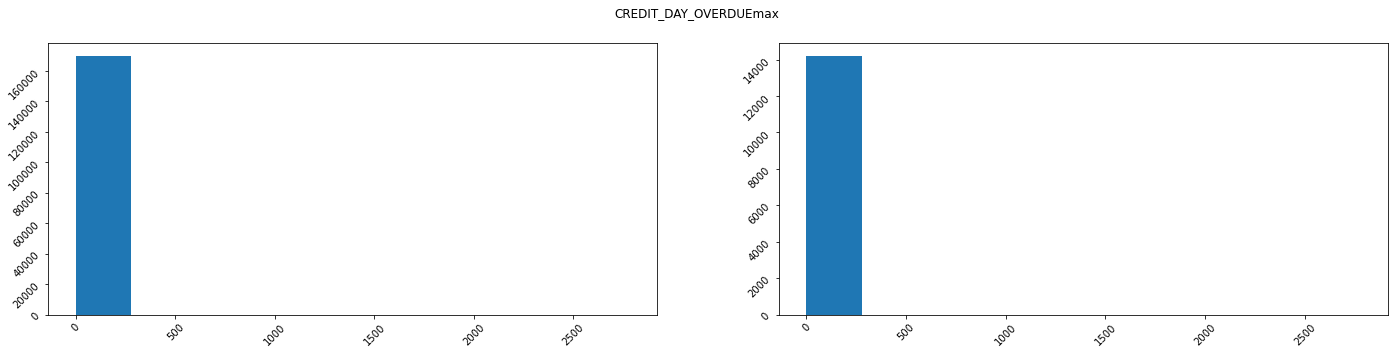

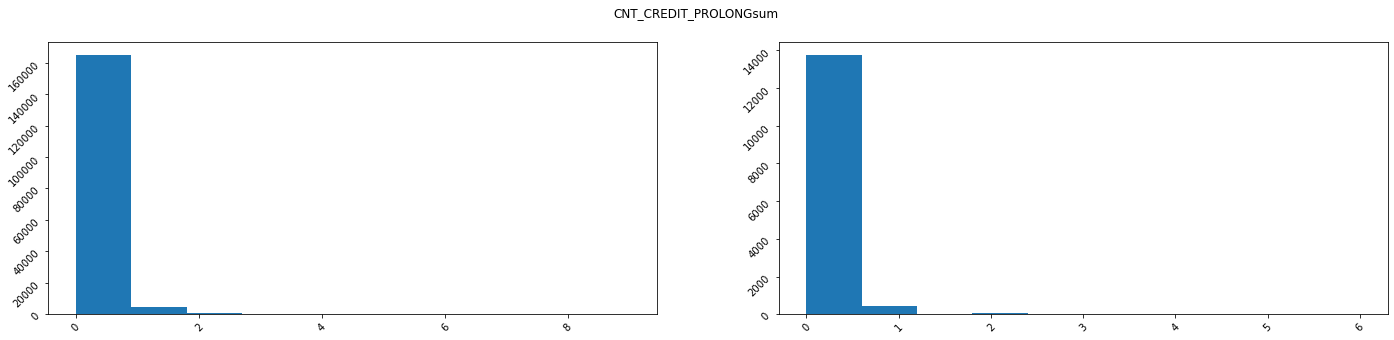

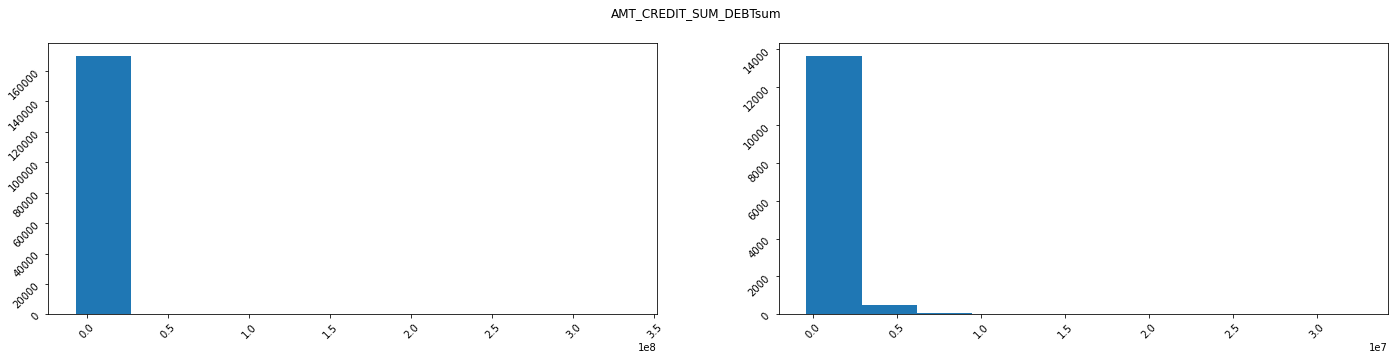

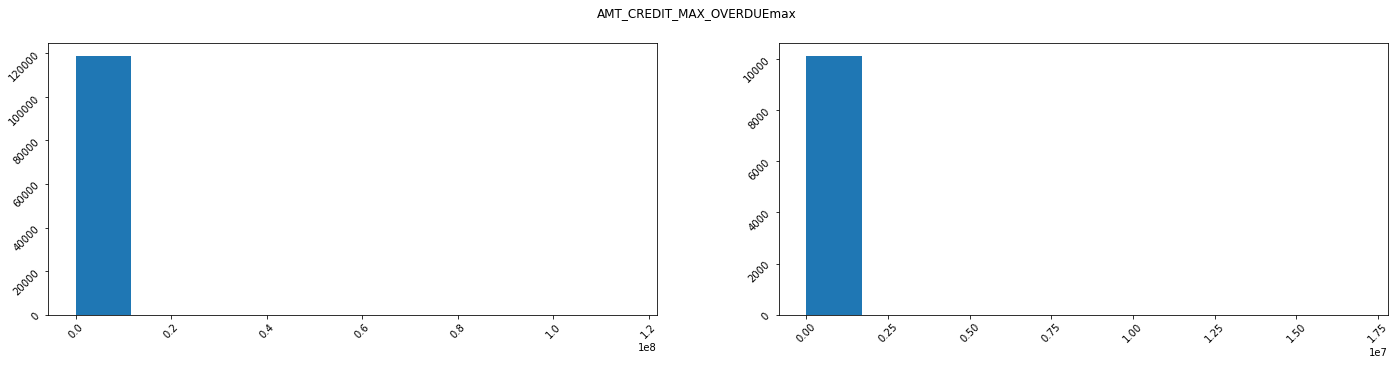

In [20]:
plot_file = model_file.merge(train_response, on='SK_ID_CURR', how='inner')
for col in [
    "CREDIT_DAY_OVERDUEmax",
    "CNT_CREDIT_PROLONGsum",
    "AMT_CREDIT_SUM_DEBTsum",
    "AMT_CREDIT_MAX_OVERDUEmax",
]:
    fig, ax = plt.subplots(1,2)
    ax[0].hist(plot_file[plot_file["TARGET"]==0][col].dropna())
    ax[0].tick_params(labelrotation=45)
    ax[1].hist(plot_file[plot_file["TARGET"]==1][col].dropna())
    ax[1].tick_params(labelrotation=45)
    fig.set_size_inches(24, 5)
    fig.suptitle(col)

### Export bureau variables

In [15]:
model_file.to_csv(model_file_output_dir + "manual.csv",index=False)